# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
import pathlib

from fastai.text import *

import numpy as np
import pandas as pd
import html

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [3]:
#path = untar_data(URLs.IMDB_SAMPLE)
path = pathlib.Path("./gov")
#path.ls()

It only contains one csv file, let's have a look at it.

In [24]:
?pd.read_csv

In [4]:
#df = pd.read_csv(path/'basepython.csv', sep=';;::;;', encoding = 'cp1252', quotechar='\"', engine='python')
df = pd.read_csv(path/'basepython2.csv', sep=';;::;;', quotechar='\"', engine='python')
#df = pd.read_csv(path/'basepython.csv', sep=';')
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
df.head()

"TEMA"  \
0  "Alteração pela empresa aérea"   
1         "Transporte de bagagem"   
2     "Alteração pelo passageiro"   
3       "Programas de Fidelidade"   
4         "Transporte de bagagem"   

                                      "MANIFESTACAO"  
0  "Descrição da Reclamação  Olá em 26/06 comprei...  
1  "Descrição da Reclamação  Prezados,  Abri o pr...  
2  "Descrição da Reclamação  No dia 17/12 comprei...  
3  "Descrição da Reclamação  Estou tendo um probl...  
4  "Descrição da Reclamação  Olá,  Minha mala ret...

In [5]:
df['"MANIFESTACAO"'][3]

'"Descrição da Reclamação  Estou tendo um problema! Recentemente fiz a compra de uma passagem para minha esposa nº 9572138082451 esse voo ela acabou perdendo pois chegou 10 minutos atrasado devido ao trânsito de São Paulo e não deixaram ela embarcar. Tivemos que fazer a remarcação para outro horário fui até a agência da LATAM dentro do Aeroporto Santa Genoveva de Goiânia e fiz a remarcação cujo nº é 9572137805000 o atendente me cobrou o valor de R$ 150,00 + 7.000 Pontos. Só que fui verificar hoje no meu extrato que foi cobrado 14.000 pontos totalmente ao contrário do que foi dito por ele! Eu quero que devolva os outros pontos que é meu por direito! Pois eu remarquei a passagem mediante a negociação no dia 24/11/2016.  Pedido à Empresa  Gostaria que fosse feito o estorno do pagamento R$ 150,00 e os 7000 pontos retirado a mais da minha conta multiplus!  Andamento  Data Descrição Autor Ações    "'

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [41]:
?TextDataBunch.from_csv

In [42]:
#data_lm = TextDataBunch.from_csv(path, 'basepython.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [7]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [8]:
data = TextDataBunch.load(path)

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [9]:
data = TextClasDataBunch.load(path)
data.show_batch()

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

In [7]:
PATH = pathlib.Path("./gov/data/")
LANG_FILENAMES = [str(f) for f in PATH.rglob("*/*")]
print(len(LANG_FILENAMES))
LANG_FILENAMES[0:5]

1610


['gov/data/AK/wiki_72',
 'gov/data/AK/wiki_35',
 'gov/data/AK/wiki_11',
 'gov/data/AK/wiki_81',
 'gov/data/AK/wiki_93']

In [45]:
LANG_TEXT = []
for i in LANG_FILENAMES:
    for line in open(i):
        LANG_TEXT.append(json.loads(line))
        
LANG_TEXT = pd.DataFrame(LANG_TEXT)

In [46]:
s = LANG_TEXT.text.str.len().sort_values(ascending=False).index
LANG_TEXT = LANG_TEXT.reindex(s)
LANG_TEXT = LANG_TEXT.reset_index(drop=True)

In [47]:
LANG_TEXT = LANG_TEXT[0:LANG_TEXT.shape[0]//21]

In [5]:
LM_PATH=Path('lm/')
LM_PATH.mkdir(exist_ok=True)

In [10]:
LM_PATH.ls()

[PosixPath('lm/test.csv'),
 PosixPath('lm/Wiki_PT_Corpus.csv'),
 PosixPath('lm/Wiki_PT_Corpus2.csv'),
 PosixPath('lm/train.csv'),
 PosixPath('lm/gov_clas')]

In [54]:
LANG_TEXT.to_csv(f"{LM_PATH}/Wiki_PT_Corpus.csv", index=False)

In [55]:
(LANG_TEXT.assign(labels = 0)
    .pipe(lambda x: x[['labels', 'text']])
    .to_csv(f"{LM_PATH}/Wiki_PT_Corpus2.csv", header=None, index=False))

In [56]:
# Getting rid of the title name in the text field
def split_title_from_text(text):
    words = text.split("\n\n")
    if len(words) >= 2:
        return ''.join(words[1:])
    else:
        return ''.join(words)
    
LANG_TEXT['text'] = LANG_TEXT['text'].apply(lambda x: split_title_from_text(x))

In [57]:
LANG_TEXT.shape

(48380, 4)

In [58]:
LANG_TEXT['text'].apply(lambda x: len(x.split(" "))).sum()

103888223

In [59]:
len(set(''.join(LANG_TEXT['text'].values).split(" ")))

3979648

In [60]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [61]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    #texts = texts.apply(fixup).values.astype(str)
    #teste
    texts = texts.apply(fixup).values.astype(str)
    tok = Tokenizer.proc_all_mp(partition_by_cores(texts), lang='pt')
    #fim teste

    #tok = Tokenizer().proc_all_mp(partition_by_cores(texts)) # splits the list into sublists for processing by each core
    # Lower and upper case is inside the tokenizer
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [ ]:
#LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_PT_Corpus2.csv", header=None)#, chunksize=5000)

In [ ]:
#LM TBC...


In [6]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [7]:
data = df
len(data)

31966

In [8]:
data.columns

Index(['"TEMA"', '"MANIFESTACAO"'], dtype='object')

In [9]:
data.dtypes

"TEMA"            object
"MANIFESTACAO"    object
dtype: object

In [10]:
data['"TEMA"'] = data['"TEMA"'].astype('category')
data.dtypes

"TEMA"            category
"MANIFESTACAO"      object
dtype: object

In [11]:
#get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
data.head(5)

"TEMA"  \
0  "Alteração pela empresa aérea"   
1         "Transporte de bagagem"   
2     "Alteração pelo passageiro"   
3       "Programas de Fidelidade"   
4         "Transporte de bagagem"   

                                      "MANIFESTACAO"  
0  "Descrição da Reclamação  Olá em 26/06 comprei...  
1  "Descrição da Reclamação  Prezados,  Abri o pr...  
2  "Descrição da Reclamação  No dia 17/12 comprei...  
3  "Descrição da Reclamação  Estou tendo um probl...  
4  "Descrição da Reclamação  Olá,  Minha mala ret...

In [12]:
data["temacode"] = data['"TEMA"'].cat.codes
#get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
data.head(5)

"TEMA"  \
0  "Alteração pela empresa aérea"   
1         "Transporte de bagagem"   
2     "Alteração pelo passageiro"   
3       "Programas de Fidelidade"   
4         "Transporte de bagagem"   

                                      "MANIFESTACAO"  temacode  
0  "Descrição da Reclamação  Olá em 26/06 comprei...         0  
1  "Descrição da Reclamação  Prezados,  Abri o pr...        10  
2  "Descrição da Reclamação  No dia 17/12 comprei...         1  
3  "Descrição da Reclamação  Estou tendo um probl...         7  
4  "Descrição da Reclamação  Olá,  Minha mala ret...        10

In [83]:
#raw = data[['"MANIFESTACAO"', '"ASSUNTO"']]
#raw = data[['"MANIFESTACAO"', '"TEMA"']]
raw = data[['temacode', '"MANIFESTACAO"']]

In [84]:
#raw = raw.rename(columns = {'"MANIFESTACAO"':'text', '"ASSUNTO"': 'label'})
#raw = raw.rename(columns = {'"MANIFESTACAO"':'text', '"TEMA"': 'label'})
raw = raw.rename(columns = {'temacode': 'label', '"MANIFESTACAO"':'text'})
#get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
raw.head(5)

label                                               text
0      0  "Descrição da Reclamação  Olá em 26/06 comprei...
1     10  "Descrição da Reclamação  Prezados,  Abri o pr...
2      1  "Descrição da Reclamação  No dia 17/12 comprei...
3      7  "Descrição da Reclamação  Estou tendo um probl...
4     10  "Descrição da Reclamação  Olá,  Minha mala ret...

In [85]:
raw.dtypes

label      int8
text     object
dtype: object

In [272]:
#import fastai.utils.collect_env; fastai.utils.collect_env.show_install(1)

In [81]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} scikit-learn scipy matplotlib

Solving environment: done

# All requested packages already installed.



In [85]:
!{sys.executable} -m pip install scikit-learn

In [82]:
import sklearn

In [83]:
import sklearn.model_selection

In [92]:
?sklearn.*

In [16]:
trn, val = sklearn.model_selection.train_test_split(
    raw, test_size=0.1)

In [17]:
trn, tst = sklearn.model_selection.train_test_split(
    trn, test_size=0.15)

In [24]:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [18]:
trn.head(5)

text  label
11307  "Descrição da Reclamação  Prezados, Gostaria d...      6
20902  "Descrição da Reclamação  Adquiri passagem, cu...      8
19498  "Descrição da Reclamação  O Vôo (SP- Londrina)...      3
14702  "Descrição da Reclamação  comprei duas passage...      5
22017  "Descrição da Reclamação  No dia 11/06/2018, p...      3

In [19]:
len(trn), len(val), len(tst)

(24453, 3197, 4316)

In [20]:
trn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24453 entries, 11307 to 31589
Data columns (total 2 columns):
text     24453 non-null object
label    24453 non-null int8
dtypes: int8(1), object(1)
memory usage: 406.0+ KB


In [21]:
#CLASSES = ['neg', 'pos', 'unsup']
CLASSES = data['"TEMA"'].unique().astype('object')
for labeltest in enumerate(CLASSES):
    print(labeltest)

(0, '"Alteração pela empresa aérea"')
(1, '"Transporte de bagagem"')
(2, '"Alteração pelo passageiro"')
(3, '"Programas de Fidelidade"')
(4, '"Oferta e compra"')
(5, '"Reclamações contra valores e regras do contrato"')
(6, '"Execução do voo"')
(7, '"Check-in e embarque"')
(8, '"Outros"')
(9, '"Assistência ao PNAE"')
(10, '"Reembolso"')


In [22]:
CLASSES.sort(0);CLASSES

array(['"Alteração pela empresa aérea"', '"Alteração pelo passageiro"', '"Assistência ao PNAE"',
       '"Check-in e embarque"', '"Execução do voo"', '"Oferta e compra"', '"Outros"',
       '"Programas de Fidelidade"', '"Reclamações contra valores e regras do contrato"', '"Reembolso"',
       '"Transporte de bagagem"'], dtype=object)

In [6]:
CLAS_PATH=Path('lm/gov_clas/')
CLAS_PATH.mkdir(exist_ok=True)

In [91]:
trn = trn[['label', 'text']]

In [93]:
val = val[['label', 'text']]

In [94]:
trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w', encoding='utf-8').writelines(f'{o}\n' for o in CLASSES)

In [25]:
trn.text.head()

11307    "Descrição da Reclamação  Prezados, Gostaria d...
20902    "Descrição da Reclamação  Adquiri passagem, cu...
19498    "Descrição da Reclamação  O Vôo (SP- Londrina)...
14702    "Descrição da Reclamação  comprei duas passage...
22017    "Descrição da Reclamação  No dia 11/06/2018, p...
Name: text, dtype: object

In [26]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn.text,val.text]), test_size=0.1)

In [27]:
len(trn_texts), len(val_texts)

(24885, 2765)

In [28]:
trn_texts[1]

'"Descrição da Reclamação  Antes da minha viagem liguei no call center Latam para alteracao do numero de milhagem da minha reserva da American para Multiplus, e me foi garantido pelo atendente que estava alterado conforme a minha solicitacao. Peco a gentileza de buscarem esta ligacao.  Ao retornar de viagem, as milhas nao foram computadas automaticamente, e alguns meses depois me foi informado pelo sac latam que as minhas estavam no programa da American, para entrar em contato com esta cia aérea. A American informa que uma vez as milhas computadas, não é possivel fazer estorno.  Não utilizarei estas minhas na conta da American, e conforme minha solicitação prévia e confirmação via telefone, gostaria de obter as milhas em minha conta Multiplus.  Pedido à Empresa  Não utilizarei as minhas da conta da American, e conforme minha solicitação prévia e confirmação via telefone do atendente Antes da minha viagem, gostaria de obter as milhas faltantes em minha conta Multiplus.  Informações Adic

In [29]:
col_names = ['labels','text']

In [7]:
LM_PATH=Path('lm/')
LM_PATH.mkdir(exist_ok=True)

In [32]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False, sep='Ä')
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False, sep='Ä')

In [8]:
chunksize=24000

In [9]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [10]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)
#    texts = texts.apply(fixup).values.astype(str)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts), lang='pt')
#    tok = Tokenizer().process_all(partition_by_cores(texts, 4))
    return tok, list(labels)

In [11]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
#u    for i, r in enumerate(n_lbls):
        print(i)
 #       print(r)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels


In [37]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize, sep='Ä', engine='python')
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize, sep='Ä', engine='python')

In [44]:
#for chunk in df_val:
#    print(chunk)

In [38]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0


In [39]:
tok_val

[['\n',
  'xbos',
  'xfld',
  '1',
  '"',
  'descrição',
  'da',
  'reclamação',
  'na',
  'terça',
  'feira',
  'dia',
  '02',
  '/',
  '01',
  'no',
  'aeroporto',
  'de',
  'manaus',
  'a',
  'o',
  'despachar',
  'a',
  'bagagem',
  'por',
  'volta',
  'das',
  '00:00hs',
  '(',
  'com',
  'o',
  'check',
  'in',
  'já',
  'feito',
  ')',
  'fui',
  'informada',
  'de',
  'que',
  'o',
  'voo',
  't_up',
  'jj3435',
  '(',
  'manaus',
  '-',
  'brasília',
  ')',
  'sairia',
  'com',
  'atraso',
  '(',
  'sem',
  'informações',
  'adicionais',
  'sobre',
  'o',
  'tempo',
  'de',
  'atraso',
  ')',
  'e',
  ',',
  'consequentemente',
  ',',
  'comprometeria',
  'a',
  'minha',
  'conexão',
  'em',
  'brasília',
  ',',
  'cujo',
  'voo',
  't_up',
  'jj3416',
  '(',
  'brasília',
  '-',
  'recife',
  ')',
  'sairia',
  'à',
  's',
  '7:10hs',
  '.',
  'um',
  'funcionário',
  'da',
  't_up',
  'latam',
  'do',
  'balcão',
  'de',
  'atendimento',
  'no',
  'aeroporto',
  'de',
  'man

In [40]:
df_trn

In [41]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [42]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [43]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [44]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[(',', 300728),
 ('t_up', 270227),
 ('de', 254789),
 ('a', 211591),
 ('.', 202742),
 ('o', 185118),
 ('que', 169551),
 ('e', 160420),
 ('/', 132175),
 ('da', 127531),
 ('do', 104953),
 ('para', 95866),
 ('no', 82304),
 ('não', 77562),
 ('em', 74973),
 ('"', 70422),
 ('descrição', 67198),
 ('com', 66471),
 ('data', 51858),
 ('empresa', 49594),
 (')', 42730),
 ('-', 42138),
 ('(', 40579),
 ('à', 40479),
 ('dia', 39990)]

In [45]:
max_vocab = 60000
min_freq = 2

In [46]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [47]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

31364

In [48]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [49]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [50]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [51]:
vs=len(itos)
vs,len(trn_lm)

(31364, 24885)

In [12]:
em_sz,nh,nl = 400,1150,3

In [13]:
PATH = pathlib.Path("./gov/data/")

In [14]:
PATH.ls()

AttributeError: 'PosixPath' object has no attribute 'ls'

In [15]:
PRE_PATH = PATH/'models'
PRE_LM_PATH = PRE_PATH/'lm_PT_1_cycle_10_epochs_from_scratch.h5'

In [16]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [17]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [18]:
itos2 = pickle.load((PRE_PATH/'itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [19]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

NameError: name 'vs' is not defined

In [85]:
#import spacy.tokenizer
#import gc
#import sklearn
#import torch

In [61]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [20]:
wd=1e-7
bptt=70
bs=16 #was 52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [63]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [21]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [65]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [66]:
learner.model.load_state_dict(wgts)

In [67]:
lr=1e-3
lrs = lr

In [68]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      4.069137   3.800342   0.318816  



[array([3.80034]), 0.31881624820381205]

In [69]:
learner.save('lm_last_ft')

In [70]:
learner.load('lm_last_ft')

In [71]:
learner.unfreeze()

In [72]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      3.809188   3.708401   0.32907   



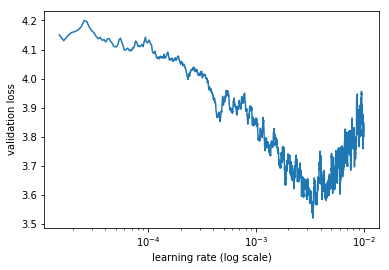

In [73]:
learner.sched.plot()

In [74]:
#learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=3)

epoch      trn_loss   val_loss   accuracy                     
    0      3.378428   3.229842   0.381036  
    1      3.238178   3.140999   0.392332                     
    2      3.166396   3.105565   0.397252                     



[array([3.10556]), 0.39725247183802276]

In [75]:
learner.save('lm1')

In [76]:
learner.save_encoder('lm1_enc')

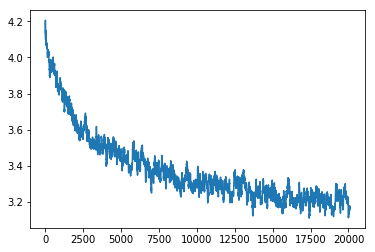

In [77]:
learner.sched.plot_loss()

Classifier tokens

In [95]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [96]:
#for chunk in df_trn:
 #   print(chunk)

In [97]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0


In [98]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [99]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [32]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

31364

In [101]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [102]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

Classifier

In [23]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [24]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [212]:
len(trn_clas)

24454

In [196]:
vctest = val_clas.copy()

In [213]:
len(trn_labels)

24453

In [200]:
vctest.shape

(3198,)

In [206]:
#vctest

In [25]:
trn_clas.resize((len(trn_clas)+1,))

In [26]:
trn_clas[-1] = trn_clas[0]

In [27]:
val_clas.resize((len(val_clas)+1,))

In [28]:
val_clas[-1] = val_clas[0]

In [204]:
vctest[-1] = vctest[0]

In [180]:
len(trn_labels)

24453

In [33]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
#bs = 48
bs = 8

In [34]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [29]:
val_labels = np.append(val_labels, val_labels[0])

In [30]:
trn_labels = np.append(trn_labels, trn_labels[0])

In [221]:
len(val_clas)

3198

In [35]:
#len(np.concatenate(val_clas, np.array([val_clas[0]])))

In [152]:
#trn_clas = np.append(trn_clas, trn_clas[0])

In [36]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [37]:
len(trn_labels)

24454

In [154]:
#len(np.append(val_labels, val_labels[0]))

In [38]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [39]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [40]:
nh

1150

In [41]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [42]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [43]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

In [44]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [45]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [46]:
wd = 1e-7
#wd = 0
learn.load_encoder('lm1_enc')

In [233]:
learn.freeze_to(-1)

 75%|███████▌  | 4594/6114 [14:38<03:45,  6.75it/s, loss=6.01]

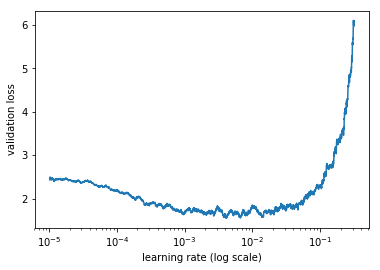

In [234]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [235]:
#learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))
#learn.precompute = False
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(20,10))

epoch      trn_loss   val_loss   accuracy                     
    0      1.381942   1.127192   0.635084  


[array([1.12719]), 0.6350844277673546]

In [236]:
learn.save('clas_0')

In [237]:
learn.load('clas_0')

In [238]:
learn.freeze_to(-2)

In [239]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.395755   1.307451   0.666979  


[array([1.30745]), 0.6669793621013134]

In [240]:
learn.save('clas_1')

In [47]:
learn.load('clas_1')

tahan asti

In [48]:
learn.unfreeze()

In [49]:
#learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))
learn.fit(lrs, 1, wds=wd, cycle_len=4, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                       
    0      1.244387   1.066028   0.677924  
  8%|▊         | 490/6114 [03:06<37:51,  2.48it/s, loss=1.39]  

KeyboardInterrupt: 

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save('clas_2')

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [10]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [11]:
data.train_ds[0][0]

Text xxbos i 'm sorry , i had high hopes for this movie . xxmaj unfortunately , it was too long , too thin and too weak to hold my attention . xxmaj when i realized the whole movie was indeed only about an older guy xxunk his dream , i felt cheated . xxmaj surely it could have been a device to bring us into something deeper , something more meaningful . 

 xxmaj so , do n't buy a large drink or you 'll be running to the rest room . xxmaj my kids did n't enjoy it either . xxmaj ah well .

But the underlying data is all numbers

In [12]:
data.train_ds[0][0].data[:10]

array([   2,   18,  173,  900,    9,   18,   85,  371, 2468,   27])

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [13]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [14]:
bs=16

Now let's grab the full dataset for what follows.

In [15]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/pekka/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/pekka/.fastai/data/imdb/train'),
 PosixPath('/home/pekka/.fastai/data/imdb/unsup'),
 PosixPath('/home/pekka/.fastai/data/imdb/README'),
 PosixPath('/home/pekka/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/pekka/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/pekka/.fastai/data/imdb/test')]

In [16]:
(path/'train').ls()

[PosixPath('/home/pekka/.fastai/data/imdb/train/neg'),
 PosixPath('/home/pekka/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/pekka/.fastai/data/imdb/train/pos'),
 PosixPath('/home/pekka/.fastai/data/imdb/train/labeledBow.feat')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviex lefts by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [17]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('tmp_lm')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [18]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [19]:
data_lm.show_batch()

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [20]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


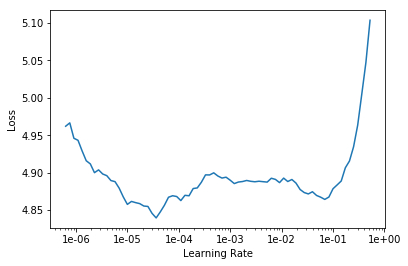

In [22]:
learn.recorder.plot(skip_end=15)

In [23]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

In [24]:
learn.save('fit_head')

In [25]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [28]:
import torch
import gc; gc.collect()
torch.cuda.empty_cache()

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

In [ ]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because of the cool scenery and the high level of xxmaj british hunting . xxmaj the only thing this movie has going for it is the horrible acting and no script . xxmaj the movie was a big disappointment . xxmaj
I liked this movie because it was one of the few movies that made me laugh so hard i did n't like it . xxmaj it was a hilarious film and it was very entertaining . 

 xxmaj the acting was great , i 'm


We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [ ]:
path = untar_data(URLs.IMDB)

In [ ]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('tmp_clas')

In [ ]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)

In [ ]:
data_clas.show_batch()

We can then create a model to classify those reviews and load the encoder we saved before.

In [ ]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([7.5928e-04, 9.9924e-01]))